In [1]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import clone

# Обучение модели

## Вспомогательные функции

In [2]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [3]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

## Загружаем данные из pickle

In [4]:
model_file = open('processed_data.pkl', 'rb')
data = pickle.load(model_file)
model_file.close()
data

,duration,rounds,f1_takedownTotal,f1_submissionAttempts,f1_takeovers,f1_protectionPassage,f1_hitsLegsTotal,f1_accentedHitsPositionClinchTotal,f2_takedownTotal,f2_submissionAttempts,...,f1_striking_accuracy,f1_grappling_accuracy,f1_Knockdown_ratio,f2_wins_by_knockout,f2_wins_by_submissions,f2_count_of_fights,f2_striking_accuracy,f2_grappling_accuracy,f2_Knockdown_ratio,winner
id,,,,,,,,,,,,,,,,,,,,,
5201,104.0,1.0,3.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,0.0,3.0,1.0,0.0,1.0,True
5202,52.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True
5203,59.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,4.0,False
5204,57.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,3.0,2.0,0.0,6.0,0.0,0.0,4.0,False
5205,138.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,260.0,1.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,5.0,0.0,24.0,1.0,1.0,3.0,True
6338,300.0,3.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4.0,False
5311,300.0,5.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,0.0,0.0,3.0,1.0,3.0,15.0,1.0,0.0,3.0,True


## Выбираем независимые и целевую переменные

In [5]:
X = data.drop(columns=['winner'])
y = data.winner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Пробуем случайный лес

In [6]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

### F1_score метрика

In [7]:
f1_score(y_test, y_pred_rfc)

0.8331550802139037

### Матрица ошибок и метрика accuracy

Accuracy RandomForest:  0.7507987220447284


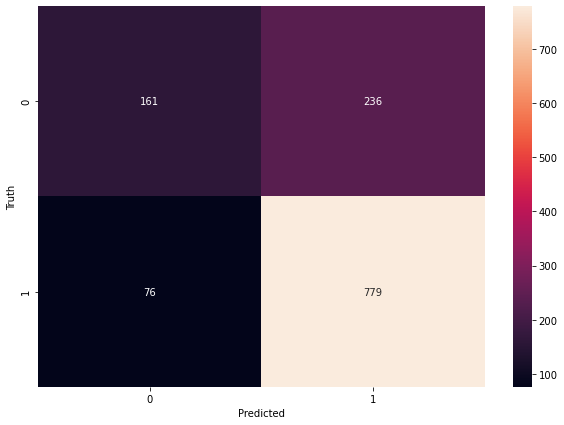

In [8]:
plt.figure(figsize=(10,7))
cmd_forest = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cmd_forest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print('Accuracy RandomForest: ', rfc.score(X_test, y_test))

## Стекинг

In [9]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1),
], X_train.values, X_test.values, y_train.values, cv)

100%|██████████| 2/2 [00:21<00:00, 10.62s/it]


In [10]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [11]:
f1_score(y_test, y_pred_clf)

0.8250825082508251

In [12]:
accuracy_score(y_test, y_pred_clf)

0.7460063897763578

In [13]:
stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
], X_train.values, X_test.values, y_train.values, cv)

100%|██████████| 2/2 [00:25<00:00, 12.79s/it]


In [14]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [15]:
f1_score(y_test, y_pred_clf)

0.8272827282728272

In [16]:
accuracy_score(y_test, y_pred_clf)

0.7492012779552716

### Стекинг с нормализацией данных

In [17]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(X_train)
cover_X_test = scaler.transform(X_test)

In [18]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1),
], cover_X_train, cover_X_test, y_train.values, cv)

100%|██████████| 2/2 [00:21<00:00, 10.72s/it]


In [19]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [20]:
f1_score(y_test, y_pred_clf)

0.8269018743109151

In [21]:
accuracy_score(y_test, y_pred_clf)

0.7492012779552716

## Пробуем бэггинг

In [22]:
import xgboost as xgb

### Преобразовываем независимые и целевую переменные

In [23]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

### Настраиваем дефолтные параметры

In [24]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

### Обучаем модель XGBoost Classifier

In [25]:
xgb_model = xgb.train(param, D_train, steps)

### Предсказываем целевую переменную

In [26]:
preds = xgb_model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Accuracy = 0.7428115015974441


In [27]:
# Мы пытались
# plt.figure(figsize=(10,7))
# cmd_xgb = confusion_matrix(D_train, D_test)
# sns.heatmap(cmd_xgb, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# print('Accuracy XGBClassifier: ', cmd_xgb.score(D_train, y_test))

# Всем спасибо, все идем спать!